In [3]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Загрузка данных

В качестве исходных данных используем массив о подлинных и истинных купюрах (https://archive.ics.uci.edu/ml/datasets/banknote+authentication).
Данные были извлечены из изображений, которые были взяты из подлинных и поддельных образцов, похожих на банкноты. Для оцифровки использовалась промышленная камера, обычно используемая для проверки печати. Окончательные изображения имеют 400x 400 пикселей. Исходные признаки были получены с помощью преобразования Вейвлета.

$x^2$

In [4]:
data = pd.read_csv('data_banknote_authentication.txt', sep=',', header=None)

Посмотрим несколько записей из массива.

In [5]:
data.head(10)

,0,1,2,3,4
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.4621,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,NaN,9.5228,-4.01120,-3.5944,0
4,0.32924,-4.4552,4.57180,-0.9888,0
5,4.36840,9.6718,-3.96060,-3.1625,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


Переименуем названия признаков в интерпретируемые.
* variance - дисперсия
* skewness - ассиметрия
* kurtosis - эксцесс
* entropy - энтропия изображения
* class - выходной класс

In [6]:
data.columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']

In [7]:
data.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.4621,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,NaN,9.5228,-4.0112,-3.5944,0
4,0.32924,-4.4552,4.5718,-0.9888,0


# 2. Предварительный анализ

Количество элементво в выборке.

In [8]:
data.shape

(1372, 5)

Итого: 1372 записи (немного), 5 признаков.

### Изучим исходные признаки.

In [9]:
features = ['variance', 'skewness', 'kurtosis', 'entropy']
data[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 4 columns):
variance    1368 non-null float64
skewness    1372 non-null float64
kurtosis    1372 non-null float64
entropy     1372 non-null object
dtypes: float64(3), object(1)
memory usage: 42.9+ KB


Сразу видно, что в признаке variance имеются пропуски.

In [10]:
data[features].describe()

,variance,skewness,kurtosis
count,1368.000000,1372.000000,1372.000000
mean,0.428956,1.922353,1.397627
std,2.843512,5.869047,4.310030
min,-7.042100,-13.773100,-5.286100
25%,-1.780075,-1.708200,-1.574975
50%,0.491840,2.319650,0.616630
75%,2.811525,6.814625,3.179250
max,6.824800,12.951600,17.927400


In [11]:
data['entropy'].value_counts()

-0.9888      5
-0.2957      5
-7.5034      4
0.36119      4
0.3211       4
-0.5621      4
-0.4444      4
-0.9849      4
-0.23751     4
?            3
0.6017       3
0.5461       3
-1.872       3
-0.12243     3
-0.53104     3
-5.8638      3
0.96765      3
-6.8103      3
-0.61251     3
1.1189       3
-1.4543      3
-2.5276      3
0.62627      3
-0.12889     3
-0.65259     3
0.003003     3
0.34179      3
-5.4707      3
0.49826      3
-1.8384      3
            ..
-3.2194      1
-1.5487      1
-2.0815      1
-4.1633      1
-2.8224      1
0.42455      1
-1.0573      1
-1.6599      1
1.6556       1
-1.175       1
-6.4172      1
-4.3379      1
1.3323       1
-2.9452      1
0.41421      1
-0.46122     1
-0.066824    1
-1.0974      1
-1.2371      1
2.0564       1
-3.6345      1
-3.4004      1
-0.30993     1
-2.1784      1
-4.3664      1
-0.66811     1
-2.6608      1
-5.2107      1
1.0245       1
-1.1181      1
Name: entropy, Length: 1155, dtype: int64

In [12]:
data[data['entropy'] != '?']['entropy']

0       -0.44699
1        -1.4621
2        0.10645
3        -3.5944
4        -0.9888
5        -3.1625
6        0.56421
7       -0.60216
8       -0.61251
9       -0.73535
10      -0.80647
11       0.86291
12       -3.1108
13       -2.9362
14      -0.57242
15        1.4771
16       0.58619
17        0.6017
18       -2.1086
19       -4.1013
20      -0.48708
21       -0.9888
22       -4.0172
23       -1.6599
24       -3.7483
25       -2.8715
26      -0.63578
27       -3.7405
28       -3.2258
29        1.0905
          ...   
1342       1.212
1343     0.32886
1344      1.3258
1345     -2.1112
1346     -5.8741
1347     -5.9181
1348    -0.40173
1349      0.9017
1350     0.56421
1351    0.065071
1352     -1.4259
1353     -2.8457
1354     -3.5233
1355     -3.6345
1356    -0.65389
1357     0.42972
1358    0.003003
1359    -0.62156
1360    -0.80518
1361     -0.8388
1362      -1.678
1363     0.66119
1364    -0.42113
1365    -0.52846
1366     -1.2953
1367    -0.55949
1368     0.34179
1369     -2.77

In [13]:
d = {'?': 10}
data['entropy'] = data['entropy'].replace(d).astype('float')

Построим гистограммы для исходных признаков.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116c081d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116d8db90>]], dtype=object)

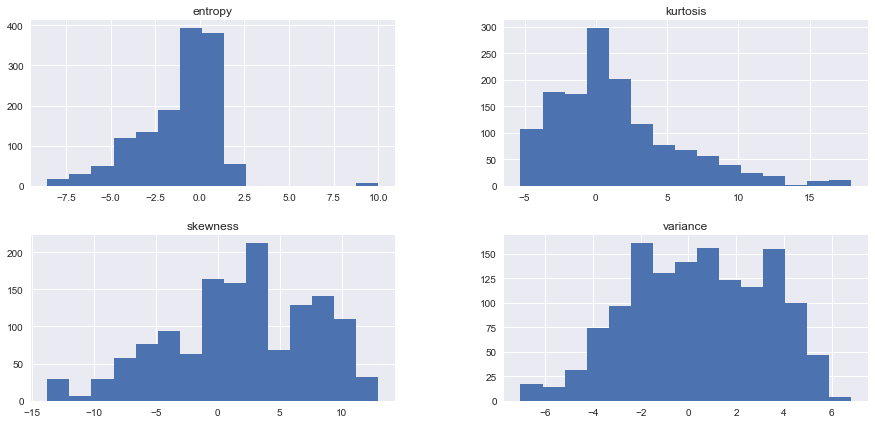

In [13]:
data[features].hist(bins=15, figsize=(15,7))

### Проанализируем целевую переменную.

In [14]:
data['class'] = data['class'].astype('bool')
data['class'].describe()

count      1372
unique        2
top       False
freq        762
Name: class, dtype: object

False    762
True     610
Name: class, dtype: int64


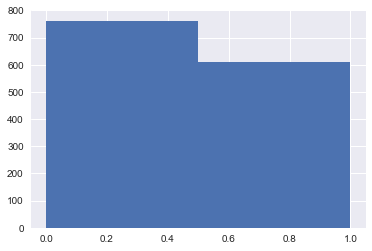

In [15]:
data['class'].hist(bins=2)
print data['class'].value_counts()

Классы немного несбалансированы, но не страшно.

### Корреляционный анализ

          variance  skewness  kurtosis   entropy     class
variance  1.000000  0.263174 -0.379617  0.275830 -0.725054
skewness  0.263174  1.000000 -0.786895 -0.500726 -0.444688
kurtosis -0.379617 -0.786895  1.000000  0.311278  0.155883
entropy   0.275830 -0.500726  0.311278  1.000000 -0.040882
class    -0.725054 -0.444688  0.155883 -0.040882  1.000000


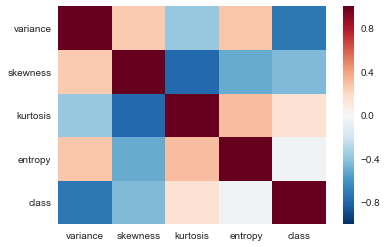

In [16]:
print data.corr()
sns.heatmap(data.corr())

Поскольку считать корреляцию между категориальной переменной и вещественной некорректно, построим диаграмму рассеяния для дисперсии и целевой переменной.

In [ ]:
sns.regplot(x="variance", y="class", data=data)

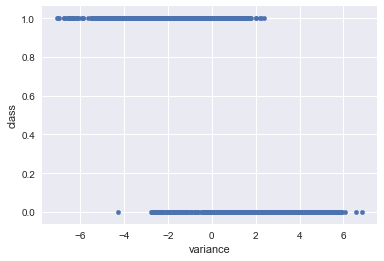

In [17]:
data.plot.scatter(x="variance", y="class")

Видно, что при больших значениях дисперсии вероятность получить фальшивую купюру больше.

# 3. Подготовка данных

Из процедур подготовки данных необходимо только заполнить пропущенные значения для признака variance. Поскольку минимальное значение -7, а максимальное 6.8, заполним пропущенные значения -15.

In [18]:
data['variance'].fillna(-15, inplace=True)

Разделим исходную выборку на X и y.

In [19]:
X = data[features]
y = data['class']

# 4. Обучение и тестирование моделей

Итак, начнем обучать и тестировать модели.

Для начала зафиксируем random_state.

In [20]:
random_state = 15

### Критерии расщепления

Проведем сравнение ДР с параметрами по умолчанию, но с разными критериями расщепления.

In [21]:
criteria = ['gini', 'entropy']

for cr in criteria:
    # ToDo
    clf = DecisionTreeClassifier(...)
    scores = cross_val_score(...)
    print 'Criterion: {}, sccuracy score: {}'.format(cr, scores.mean())

Criterion: gini, sccuracy score: 0.978139349701
Criterion: entropy, sccuracy score: 0.986155275382


Видим, что модели с параметрами по умолчанию уже дали прекрасные результаты. Посмотрим, можно ли что-то улучшить.

### Количество признаков (max_features)

In [22]:
max_features = range(2, 5)

for mf in [2,3,4]:
    # ToDo
    clf = DecisionTreeClassifier(...)
    scores = cross_val_score(...)
    print 'Criterion: {}, sccuracy score: {}'.format(cr, scores.mean())

Max features: 2, sccuracy score: 0.98397080292
Max features: 3, sccuracy score: 0.987612475116
Max features: 4, sccuracy score: 0.986155275382


Оптимальное количество = 3.

### Глубина дерева (max_depth)

Max depth: 2, accuracy score: 0.898686131387
Max depth: 3, accuracy score: 0.892862641009
Max depth: 4, accuracy score: 0.953356337094
Max depth: 5, accuracy score: 0.97302189781
Max depth: 6, accuracy score: 0.979583278036
Max depth: 7, accuracy score: 0.983232913072
Max depth: 8, accuracy score: 0.987612475116
Max depth: 9, accuracy score: 0.987612475116
Max depth: 10, accuracy score: 0.987612475116
Max depth: 11, accuracy score: 0.987612475116
Max depth: 12, accuracy score: 0.987612475116
Max depth: 13, accuracy score: 0.987612475116
Max depth: 14, accuracy score: 0.987612475116
Max depth: 15, accuracy score: 0.987612475116
Max depth: 16, accuracy score: 0.987612475116
Max depth: 17, accuracy score: 0.987612475116
Max depth: 18, accuracy score: 0.987612475116
Max depth: 19, accuracy score: 0.987612475116


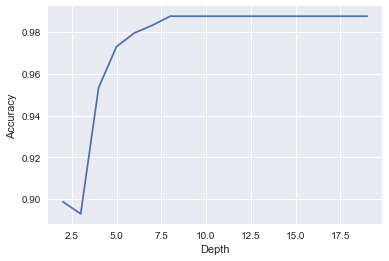

In [23]:
max_depth = range(2, 20)
scoring = []

for md in max_depth:
    # ToDo
    clf = DecisionTreeClassifier(...)
    scores = cross_val_score(...)
    print 'Criterion: {}, sccuracy score: {}'.format(cr, scores.mean())
    
plt.plot(max_depth, scoring)
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Итак, оптимальная глубина = 8.

# 5. Визуализация ДР

Выведем в pdf дерево решений с оптимальными параметрами и глубиной 3.

In [24]:
from sklearn.tree import export_graphviz

for depth in [3,8]:
    clf = DecisionTreeClassifier(criterion='entropy', max_features=3, max_depth=depth, random_state=random_state)
    clf.fit(X, y)
    export_graphviz(clf, out_file='tree{}.dot'.format(depth))

Теперь из dot файла можно сгенерировать png.

In [25]:
!dot -Tpng tree3.dot -o tree3.png
!dot -Tpng tree8.dot -o tree8.png

<img src="tree3.png">

<img src="tree8.png">

# Ансамбли деревьев решений

# 1. RandomForestClassifier

In [2]:
from sklearn.ensemble import RandomForestClassifier

Сначала зафиксируем размер леса (n_estimators = 50) и попробуем поварировать количество признаков (max_features)

### Количества признаков (max_features)

In [4]:
%%time 
mf = range(2, 5)
scores = []
for max_features in mf:
    clf = RandomForestClassifier()
    score = cross_val_score(clf, DataArray, target, cv = 5)
    print 'Max features: {}, sccuracy score: {}'.format(max_features, score.mean())

NameError: name 'random_state' is not defined

### Максимальная глубина (max_depth)

In [ ]:
%%time
md = range(2, 20)
scores = []
for max_depth in md:
    clf = RandomForestClassifier(max_features = max_features)
    score = cross_val_score()
    print 'Max depth: {}, sccuracy score: {}'.format(max_depth, score.mean())
max_accuracy = max(scores)

Максимальная глубина = 9

### Размер леса (n_estimators)

In [ ]:
%%time 
ne = range(10, 200, 10)
scores = []
for n_estimators in ne:
    clf = RandomForestClassifier(n_estimate = n_estimators)
    score = cross_val_score()
    print 'N estimators: {}, sccuracy score: {}'.format(n_estimators, score.mean())

# GradientBoostingClassifier

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

### Количества признаков (max_features)

In [ ]:
%%time 
mf = range(mf_min, mf_max)
scores = []
for max_features in mf:
    clf = GradientBoostingClassifier(random_state = random_state)
    score = cross_val_score()
    print 'Max features: {}, sccuracy score: {}'.format(max_features, score.mean())


### Максимальная глубина (max_depth)

In [ ]:
%%time 
for max_depth in range(2, 20):
    clf = GradientBoostingClassifier()
    score = cross_val_score()
    scores.append(score.mean())
    print 'Max depth: {}, sccuracy score: {}'.format(max_depth, score.mean())


### Размер леса (n_estimators)

In [ ]:
%%time 
for n_estimators in range(10, 200, 10):
    clf = GradientBoostingClassifier()
    score = cross_val_score()
    scores.append(score.mean())
    print 'N estimators: {}, sccuracy score: {}'.format(n_estimators, score.mean())

Посмотреть feature importance